In [2]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import pathlib
data_root_orig = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    fname='flower_photos', untar=True
)
data_root = pathlib.Path(data_root_orig)


228818944/228813984 [==============================] - 2009s 9us/step


In [3]:
print(data_root)

/home/ma/.keras/datasets/flower_photos


In [4]:
for item in data_root.iterdir():
    print(item)


/home/ma/.keras/datasets/flower_photos/roses
/home/ma/.keras/datasets/flower_photos/tulips
/home/ma/.keras/datasets/flower_photos/sunflowers
/home/ma/.keras/datasets/flower_photos/daisy
/home/ma/.keras/datasets/flower_photos/LICENSE.txt
/home/ma/.keras/datasets/flower_photos/dandelion


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)


In [6]:
image_count

3670

In [7]:
all_image_paths[:10]


['/home/ma/.keras/datasets/flower_photos/dandelion/2161283279_02ea3ff8d4.jpg',
 '/home/ma/.keras/datasets/flower_photos/daisy/19653086178_28156b7ce4_m.jpg',
 '/home/ma/.keras/datasets/flower_photos/tulips/7179796338_05e8b1c87b.jpg',
 '/home/ma/.keras/datasets/flower_photos/daisy/6910811638_aa6f17df23.jpg',
 '/home/ma/.keras/datasets/flower_photos/tulips/14093907931_dd8f642574.jpg',
 '/home/ma/.keras/datasets/flower_photos/roses/8642943283_47e44d049d_m.jpg',
 '/home/ma/.keras/datasets/flower_photos/sunflowers/9482209981_bf7bf6022b_m.jpg',
 '/home/ma/.keras/datasets/flower_photos/daisy/450128527_fd35742d44.jpg',
 '/home/ma/.keras/datasets/flower_photos/dandelion/13942846777_5571a6b0a1_n.jpg',
 '/home/ma/.keras/datasets/flower_photos/daisy/18203367608_07a04e98a4_n.jpg']

In [8]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]


In [9]:
attributions = dict(attributions)


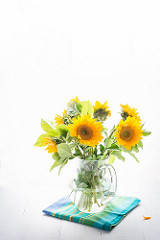

Image (CC BY 2.0)  by Shanna S



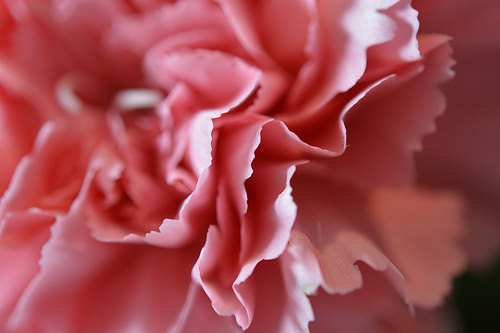

Image (CC BY 2.0)  by Heather



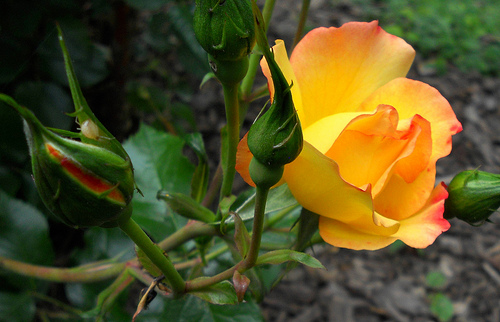

Image (CC BY 2.0)  by Rosa Dik 009 -- on & off



In [10]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + '-'.join(attributions[str(image_rel)].split(' - ')[:-1])

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()


In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

In [12]:
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))


In [14]:
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [15]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])


First 10 labels indices:  [1, 0, 4, 0, 4, 2, 3, 0, 1, 0]


In [16]:
img_path = all_image_paths[0]


In [17]:
image_path

'/home/ma/.keras/datasets/flower_photos/roses/7345657862_689366e79a.jpg'

In [18]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+'...')


<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x...


In [19]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)


(333, 500, 3)


In [20]:
img_final = tf.image.resize(img_tensor,[192,192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0
1.0


In [21]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192,192])
    image /= 255.0
    return image



def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


Text(0.5, 1.0, 'Dandelion')

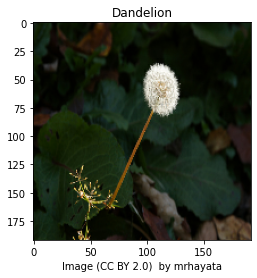

In [22]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())


In [23]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

print(path_ds)


<TensorSliceDataset shapes: (), types: tf.string>


In [24]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


In [ ]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()


In [25]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(10):
    print(label_names[label.numpy()])


roses
tulips
sunflowers
tulips
roses
roses
tulips
roses
tulips
dandelion


In [26]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

print(image_label_ds)


<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [27]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)


In [28]:
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>